In [1]:
# Create demo data that is unfair
import pandas as pd
import numpy as np
from balancers import BinaryBalancer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os

In [10]:
# Load results 
data = pd.read_csv('csvs/results/results_Cardiomegaly.csv',index_col=[0])
data = data.rename(columns={"Sex": "a", 'Cardiomegaly': "y"})
data.head()

,Patient_ID_path,Path,a,y,group,a_hat,y_prob
0,CheXpert-v1.0-small/train/patient41749,CheXpert-v1.0-small/train/patient41749/study1/...,0,0.0,4.0,0.0,0.089551
1,CheXpert-v1.0-small/train/patient16335,CheXpert-v1.0-small/train/patient16335/study1/...,1,0.0,3.0,1.0,0.022290
2,CheXpert-v1.0-small/train/patient38104,CheXpert-v1.0-small/train/patient38104/study1/...,1,0.0,3.0,1.0,0.037238
3,CheXpert-v1.0-small/train/patient27324,CheXpert-v1.0-small/train/patient27324/study2/...,0,0.0,4.0,0.0,0.048384
4,CheXpert-v1.0-small/train/patient10812,CheXpert-v1.0-small/train/patient10812/study4/...,1,0.0,3.0,1.0,0.019310


In [11]:
# Plot ROC curve and identify best threshold for J-statistic
y = data['y'].values
y_prob = data.y_prob.values
tpr = []
fpr = []
thresholds = np.linspace(0,1,101)
for t in thresholds:
    y_hat = (y_prob >= t)
    tn, fp, fn, tp = confusion_matrix(y,y_hat).ravel()
    tpr.append(tp/(tp + fn))
    fpr.append(fp/(fp + tn))

Best t =  0.13


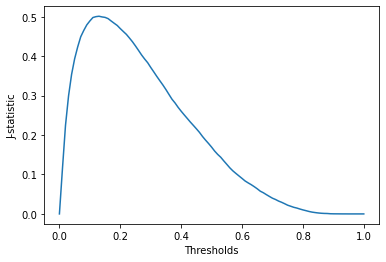

In [12]:
# Plot ROC
tpr = np.array(tpr)
fpr = np.array(fpr)
plt.plot(thresholds,tpr-fpr)
plt.xlabel('Thresholds')
plt.ylabel('J-statistic')
max_index = np.argmax(tpr-fpr)
opt_t = thresholds[max_index]
print('Best t = ', opt_t)

In [13]:
# Make unfair predictions
y = data.y.values
a = data.a.values
y_prob = data.y_prob.values.copy()
ind_1 = np.where(a==1)
ind_0 = np.where(a==0)
y_prob[ind_1] = (y_prob[ind_1] >= 0.1)
y_prob[ind_0] = (y_prob[ind_0] >= opt_t)
data['y_hat'] = y_prob
data.head()

,Patient_ID_path,Path,a,y,group,a_hat,y_prob,y_hat
0,CheXpert-v1.0-small/train/patient41749,CheXpert-v1.0-small/train/patient41749/study1/...,0,0.0,4.0,0.0,0.089551,0.0
1,CheXpert-v1.0-small/train/patient16335,CheXpert-v1.0-small/train/patient16335/study1/...,1,0.0,3.0,1.0,0.022290,0.0
2,CheXpert-v1.0-small/train/patient38104,CheXpert-v1.0-small/train/patient38104/study1/...,1,0.0,3.0,1.0,0.037238,0.0
3,CheXpert-v1.0-small/train/patient27324,CheXpert-v1.0-small/train/patient27324/study2/...,0,0.0,4.0,0.0,0.048384,0.0
4,CheXpert-v1.0-small/train/patient10812,CheXpert-v1.0-small/train/patient10812/study4/...,1,0.0,3.0,1.0,0.019310,0.0


In [14]:
# Get patient IDs
id = []
for i in range(len(data)):
    id.append(os.path.split(data.Patient_ID_path.values[i])[1])

In [23]:
# Reorganize data
data = data[['a','y','y_hat','group']]
data['patient_id'] = id
data = data[['patient_id','a','y','y_hat','group']]
data.head()

,patient_id,a,y,y_hat,group
0,patient41749,0,0.0,0.0,4.0
1,patient16335,1,0.0,0.0,3.0
2,patient38104,1,0.0,0.0,3.0
3,patient27324,0,0.0,0.0,4.0
4,patient10812,1,0.0,0.0,3.0


In [ ]:
# Save demo data
from sklearn.model_selection import train_test_split
val_data, test_data = train_test_split(data,test_size=0.8,stratify = data['group'])
val_data = val_data.reset_index()
val_data = val_data[['patient_id','a','y','y_hat']]
test_data = test_data.reset_index()
test_data = test_data[['patient_id','a','y','y_hat']]
val_data.to_csv('csvs/results/demo_validation_data' + '.csv')
test_data.to_csv('csvs/results/demo_test_data' + '.csv')


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.2583 0.7433
   1.0 0.3392 0.8342

And loss is 0.2927


Post-adjustment group rates are 

 group    fpr    tpr
   0.0 0.3097 0.7589
   1.0 0.3098 0.7584

And loss is 0.3014



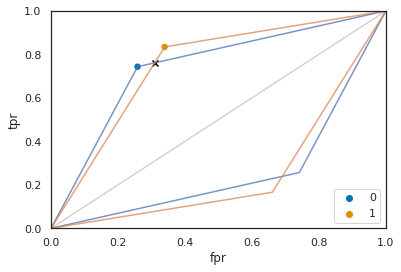

In [58]:
# Check group-wise TPRs and FPRs
y = data.y.values
y_hat = data.y_hat.values
a = data.a.values
clf = BinaryBalancer(y=y,y_=y_hat,a=a)
clf.adjust()
clf.plot(shade_hull=False)